In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for dataset - Normalizing with mean and std of Fashion MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for grayscale
])

# Download and load the training and test data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()  # Output is normalized to [-1, 1] matching the normalized input
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)  # Reshape back to image dimensions
        return x

# Instantiate the model, define the loss function and the optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [3]:
# Training function
def train_autoencoder(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Testing function (to calculate the reconstruction loss on the test set)
def test_autoencoder(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_autoencoder(model, train_loader, criterion, optimizer, device)
    test_loss = test_autoencoder(model, test_loader, criterion, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/10, Train Loss: 0.1106, Test Loss: 0.0756
Epoch 2/10, Train Loss: 0.0689, Test Loss: 0.0640
Epoch 3/10, Train Loss: 0.0605, Test Loss: 0.0579
Epoch 4/10, Train Loss: 0.0557, Test Loss: 0.0544
Epoch 5/10, Train Loss: 0.0526, Test Loss: 0.0518
Epoch 6/10, Train Loss: 0.0504, Test Loss: 0.0504
Epoch 7/10, Train Loss: 0.0489, Test Loss: 0.0492
Epoch 8/10, Train Loss: 0.0476, Test Loss: 0.0477
Epoch 9/10, Train Loss: 0.0465, Test Loss: 0.0471
Epoch 10/10, Train Loss: 0.0456, Test Loss: 0.0464


Matplotlib is building the font cache; this may take a moment.


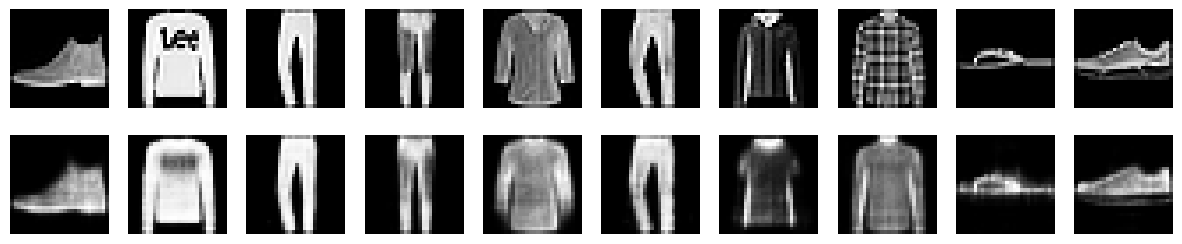

In [6]:
import matplotlib.pyplot as plt

# Function to display a few original and reconstructed images
def visualize_reconstructions(model, data_loader, device, n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            break  # Take only the first batch

    images = images.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, n, figsize=(15, 3))
    for i in range(n):
        # Original images
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    
    plt.show()

# Visualize the reconstructions
visualize_reconstructions(model, test_loader, device)
